# Section 4.1.3. GAN

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from utils import *

np.random.seed(0)
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# -------------------------------
# Define the Generator and Discriminator
# -------------------------------
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [3]:
# -------------------------------
# Loss function
# -------------------------------
def compute_discriminator_loss(discriminator, real_data, fake_data, criterion, real_label, fake_label):
    batch_size = real_data.size(0)
    # loss for real data
    real_targets = torch.full((batch_size, 1), real_label, device=real_data.device)
    d_real = discriminator(real_data)
    d_loss_real = criterion(d_real, real_targets)

    # loss for generated data
    fake_targets = torch.full((batch_size, 1), fake_label, device=real_data.device)
    d_fake = discriminator(fake_data)
    d_loss_fake = criterion(d_fake, fake_targets)

    d_loss = d_loss_real + d_loss_fake
    return d_loss

def compute_generator_loss(discriminator, fake_data, criterion, real_label):
    batch_size = fake_data.size(0)
    real_targets = torch.full((batch_size, 1), real_label, device=fake_data.device)
    d_fake = discriminator(fake_data)
    g_loss = criterion(d_fake, real_targets)
    return g_loss

# -------------------------------
# Training
# -------------------------------
def train_gan(generator, discriminator, dataloader, g_optimizer, d_optimizer, criterion, z_dim, num_epochs, device, real_label, fake_label):
    generator.train()
    discriminator.train()

    for epoch in range(1, num_epochs + 1):
        for batch in dataloader:
            real_data = batch[0].to(device)
            batch_size = real_data.size(0)

            # --- Discriminator ---
            z = torch.randn(batch_size, z_dim).to(device)
            fake_data = generator(z)
            d_loss = compute_discriminator_loss(discriminator, real_data, fake_data, criterion, real_label, fake_label)

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # --- Generator ---
            z = torch.randn(batch_size, z_dim).to(device)
            fake_data = generator(z)
            g_loss = compute_generator_loss(discriminator, fake_data, criterion, real_label)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

        if epoch % 5 == 0 or epoch == 1:
            print(f'Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

## 1. Training Stage

In [4]:
filepath = '../dataset/hts_example.csv'
z_dim = 64
hidden_dim = 512
learning_rate = 1e-4
batch_size = 512
num_epochs = 50

ground_truth_df, data_tensor, num_categories = load_and_preprocess_data(filepath, device)

dataset = torch.utils.data.TensorDataset(data_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

input_dim = data_tensor.shape[1]

# Generator and Discriminator
generator = Generator(input_dim=z_dim, output_dim=input_dim, hidden_dim=hidden_dim).to(device)
discriminator = Discriminator(input_dim=input_dim, hidden_dim=hidden_dim).to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Loss fucnction
criterion = nn.BCELoss()

real_label = 1.0
fake_label = 0.0

# Training
train_gan(generator, discriminator, dataloader, g_optimizer, d_optimizer, criterion, z_dim, num_epochs, device, real_label, fake_label)

Column 'start_type' has 5 unique categories.
Column 'act_num' has 9 unique categories.
Column 'mode_num' has 9 unique categories.
Column 'end_type' has 5 unique categories.
Epoch [1/50], D Loss: 0.5247, G Loss: 1.5819
Epoch [5/50], D Loss: 1.6098, G Loss: 0.7385
Epoch [10/50], D Loss: 1.5008, G Loss: 0.7419
Epoch [15/50], D Loss: 1.2948, G Loss: 0.7471
Epoch [20/50], D Loss: 1.1771, G Loss: 0.8659
Epoch [25/50], D Loss: 1.2562, G Loss: 0.8231
Epoch [30/50], D Loss: 1.3829, G Loss: 0.7520
Epoch [35/50], D Loss: 1.3259, G Loss: 0.7849
Epoch [40/50], D Loss: 1.3525, G Loss: 0.7151
Epoch [45/50], D Loss: 1.3577, G Loss: 0.7187
Epoch [50/50], D Loss: 1.3752, G Loss: 0.7173


## 2. Testing Stage

In [5]:
def generate_samples(generator, num_samples, z_dim, device, columns, num_categories):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, z_dim).to(device)
        samples = generator(z).cpu().numpy()

    generated_df = pd.DataFrame(samples, columns=columns)
    for column in columns:
        max_cat = num_categories[column] - 1
        generated_df[column] = np.floor(generated_df[column]).astype(int)
        generated_df[column] = np.clip(generated_df[column], 0, max_cat)
    return generated_df

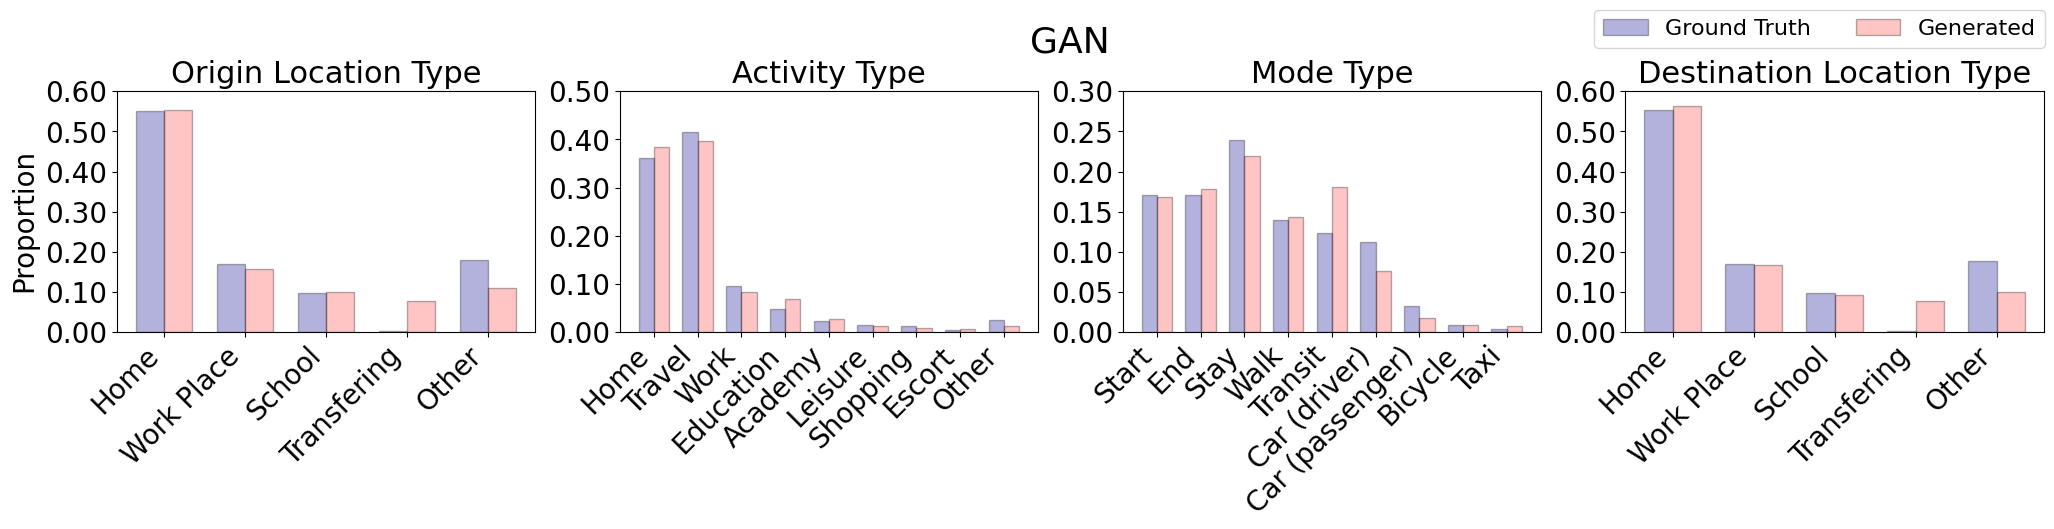

In [6]:
model_name = 'GAN'
columns = ['start_type', 'act_num', 'mode_num', 'end_type']
num_samples = 3000

generated_df = generate_samples(generator, num_samples, z_dim, device, columns, num_categories)

xtick_labels_list = [
    ['Home', 'Work Place', 'School', 'Transfering', 'Other'],  # Start Location Type
    ['Home', 'Travel', 'Work', 'Education', 'Academy', 'Leisure', 'Shopping', 'Escort', 'Other'],  # Activity Type
    ['Start', 'End', 'Stay', 'Walk', 'Transit', 'Car (driver)', 'Car (passenger)', 'Bicycle', 'Taxi'],  # Mode Type
    ['Home', 'Work Place', 'School', 'Transfering', 'Other']  # End Location Type
]

visualize_results(model_name, ground_truth_df, generated_df, columns, xtick_labels_list)